# A Notebook for Testing Non-Zero Mean Kriging Issues

Kriging assumes the data we are working with has zero mean, and PRIZM data is obviously non-zero mean, which can lead to issues in the interpolation. This may be a problem especially in bigger time gaps. Trying to test if that is the problem.

Plan: "Make a bunch of predictions and see if they tend towards zero as you get further from the data you have."

### This non-zero mean project has been put on hold for now, using this notebook to test various other things

In [1]:
import numpy as np
import statistics as stat
import scipy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import PrizmCalibration as cl # this module is missing dependencies
from gsm_data import GSMData, get_desired_frequencies
# from data_prep import DataPrep

# For reloading the module (useful for debugging)
import data
import data_prep
try:
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep
except:
    from importlib import reload
    reload(data) # dependent module (imported in data_prep)
    reload(data_prep)
    from data_prep import DataPrep

from helper_functions import *
import data_utils as du

import copy

try:
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt
except:
    import test_short_interp
    reload(test_short_interp)
    from test_short_interp import make_acf, make_acf_alt

## Step 0: Load in data

In [2]:
# Flag the 'bad' spectra
# For a first pass I have to fetch the mask from DataPrep
year = '2021'
instrument = '100MHz'
channel = 'NS'

dataprep = DataPrep(instrument, channel, year)
save_mask = copy.deepcopy(dataprep.calib_mask_dict['short']) # save the mask

TypeError: object of type 'NoneType' has no len()

In [46]:
# Actually save the mask so I don't have to load it in every time anymore.
np.save(datadir+'shortdata_2021_100MHz_NS_mask.npy',save_mask)

In [2]:
datadir = '../test_data/2021/100MHz/NS/'

save_mask = np.load(datadir+'shortdata_2021_100MHz_NS_mask.npy')
dat=np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')[save_mask]
lst=np.load(datadir+'shortlst_2021_100MHz_NS.npy')[save_mask]
t=np.load(datadir+'shortsystime_2021_100MHz_NS.npy')[save_mask]
t_ant = np.load(datadir+'antsystime_2021_100MHz_NS.npy')

# dat_nomask = np.load(datadir+'shortdata_meas_2021_100MHz_NS.npy')
# lst_nomask = np.load(datadir+'shortlst_2021_100MHz_NS.npy')
# t_nomask = np.load(datadir+'shortsystime_2021_100MHz_NS.npy')

In [3]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
minfreq = 30
maxfreq = 200
minfreqarg = int(minfreq/freqstep)
maxfreqarg = int(maxfreq/freqstep)

[6.38368225 5.95632076 7.08244133 ... 6.62320685 6.08258057 6.62830639]


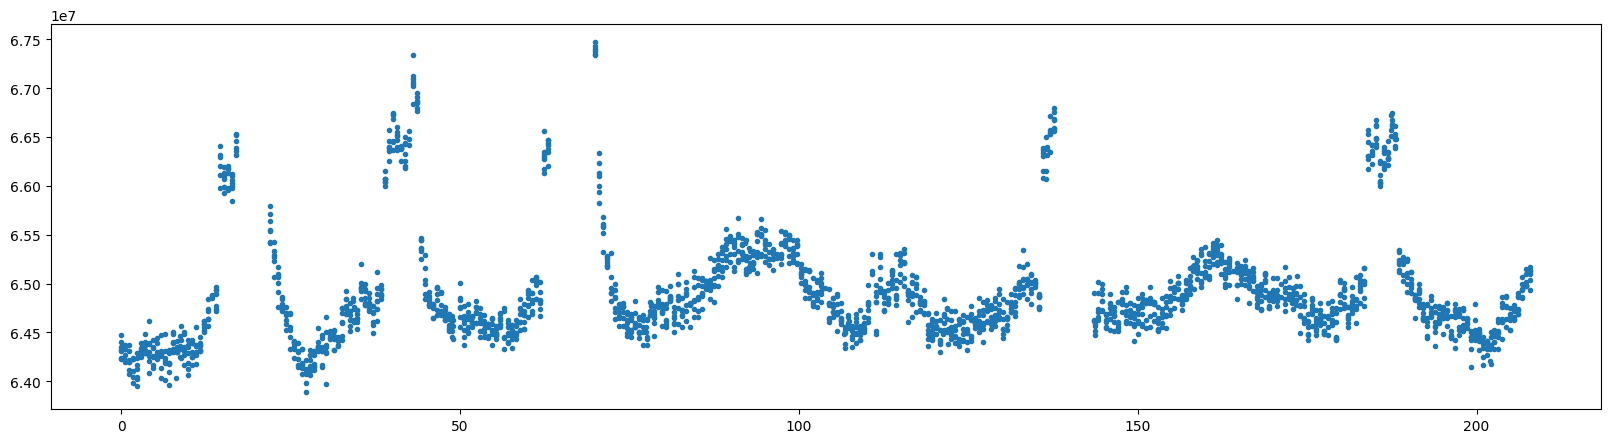

In [14]:
print(np.diff(t_nomask))
tmax=1.6374e9
tmin=1.6365e9
freq = 100 # MHz
freq_index = int(freq/freqstep)
mask=(t_nomask>tmin)&(t_nomask<tmax)
plt.figure(figsize=(20,5))
plt.plot((t_nomask[mask]-t_nomask[mask][0])/3600,dat_nomask[mask,:][:,freq_index],'.',label='Selected section',zorder=0)

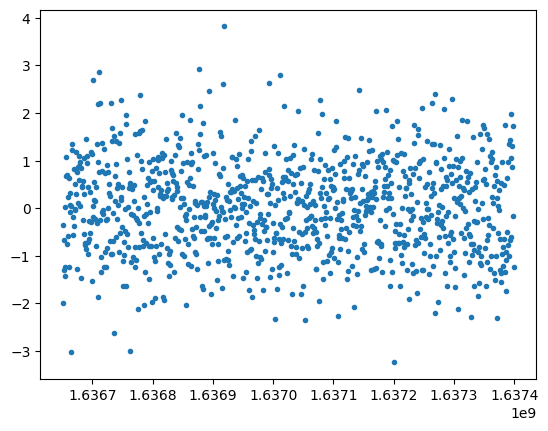

In [135]:
# White Gaussian Noise simulated data -- for testing purposes
twgn = np.linspace(np.min(tt),np.max(tt),1000)
wgn_data = np.random.normal(loc=0,scale=1,size=len(twgn))

plt.plot(twgn,wgn_data,'.',label='WGN data')
plt.show()

## Step 1: Compute the autocorrelation function (ACF)

For now (testing purposes) we restrict to:

- one frequency channel: 100 MHz

- one section of the time series

- one data point to interpolate

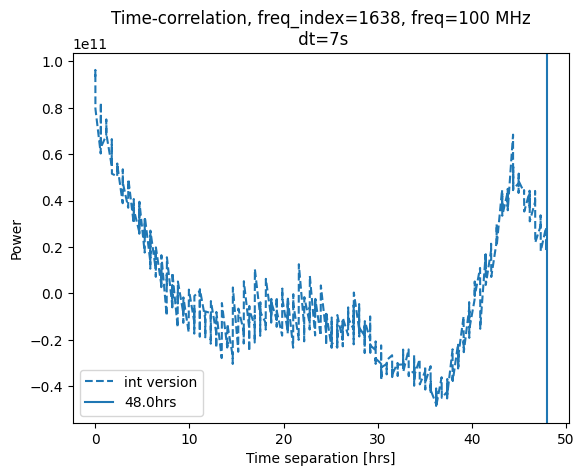

In [4]:
tmax=1.63715e9
tmin=1.6369e9

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]
ll=lst[mask]

''' Set frequency here'''
freq = 100 # MHz
freq_index = int(freq/freqstep)
'''-----------------------------'''

dt=7 # seconds
plt.clf()

tot,wt=make_acf((dd[:,freq_index]-dd[:,freq_index].mean()),tt,dt=dt,tmax=2*86400)
# tot2,wt2=make_acf_alt(dd[:,freq_index]-dd[:,freq_index].mean(),tt,dt=dt,tmax=2*86400)
# tot,wt=make_acf(dd-dd.mean(),tt,dt=dt,tmax=2*86400)
tvec=np.arange(len(tot))*dt
# tvec2=np.arange(len(tot2))*dt
mm=wt>30
# mm2=wt2>30

plt.plot(tvec[mm]/3600,(tot[mm]/wt[mm]),'--',label='int version')
# plt.plot(tvec2[mm2]/3600,(tot2[mm2]/wt2[mm2]),'.',label='np.round version')

'''Set dtmax here -- i.e. the section of the ACF data used to fit a function'''
dtmax = 48*3600 # seconds
'''------------------------------------'''

plt.axvline(x=dtmax/3600,label=str(dtmax/3600)+'hrs')

plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.legend()
plt.show()

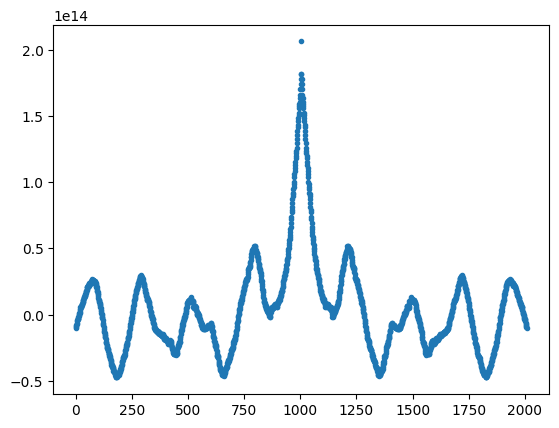

In [23]:
numpy_acf = np.correlate(dd[:,freq_index]-dd[:,freq_index].mean(),dd[:,freq_index]-dd[:,freq_index].mean(),mode='same')
plt.plot(numpy_acf,'.')

Since the autocorrelation function still looks a little weird, we will only focus use the dt = 0 to dt = 8h section.

Also we plot the data:

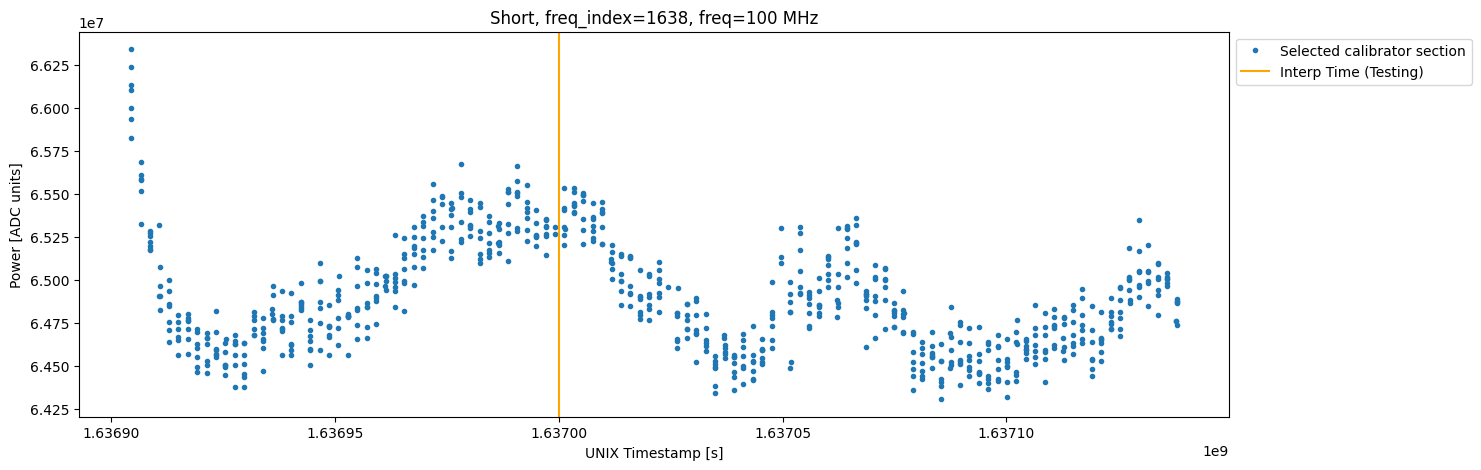

In [5]:
# vs UNIX timestamp

''' Set interp_time here'''
interp_time = 1.637e9
'''--------------------'''

plt.figure(figsize=(20,5))
# plt.plot(t,dat[:,freq_index],'.',label='All times')
# plt.scatter(t_ant[(t_ant>tmin)&(t_ant<tmax)],[6.50e7 for ti in t_ant[(t_ant>tmin)&(t_ant<tmax)]],marker='.',color='red',label='Antenna times')
plt.plot(tt,dd[:,freq_index],'.',label='Selected calibrator section')
plt.axvline(x=interp_time,label='Interp Time (Testing)',color='orange') 
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

# Step 2: Fit the autocorrelation function

In [6]:
# As a simple first pass for just the 0 to 8h section of the ACF we 
def linfunc(x,a,b):
    return a*x+b

def expfunc(x,a,b):
    return a*np.exp(-x/b)

# def expabsfunc(x,a,b):
#     return a*np.exp(-b*abs(x))

def ACF_fit(a,b,functype='linear'):
    if functype == 'linear':
        return lambda dt: a*dt+b
    elif functype == 'exponential':
        return lambda dt: a*np.exp(-dt/b)

def ACF_wgn(dt):
    if dt == 0: return np.random.normal(loc=1,scale=0.03,size=1)
    else: return np.random.normal(loc=0,scale=0.03,size=1)

In [7]:
from numpy.polynomial import polynomial as P

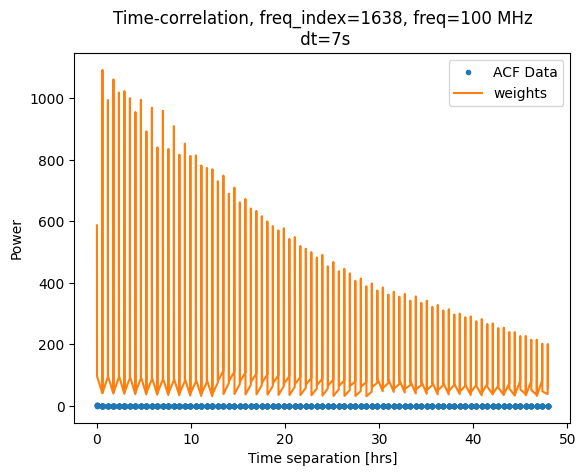

In [10]:
plt.plot(tvec[mm][tvec[mm]<dtmax]/3600,(tot[mm]/wt[mm])[tvec[mm]<dtmax]/1e11,'.',label='ACF Data')
plt.plot(tvec[mm][tvec[mm]<dtmax]/3600, wt[mm][tvec[mm]<dtmax],label='weights')
tfitvec = np.linspace(0,dtmax/3600,100)

# Do the fit:
# popt, pcov = scipy.optimize.curve_fit(f=linfunc,xdata=tvec[mm][tvec[mm]<dtmax]/3600,ydata=(tot[mm]/wt[mm])[tvec[mm]<dtmax],p0=[-6e10/8,9.1e10])
# plt.plot(tfitvec,linfunc(tfitvec,popt[0],popt[1]),label='Linear Fit')
# popt, pcov = scipy.optimize.curve_fit(f=expfunc,xdata=tvec[mm][tvec[mm]<dtmax]/3600,ydata=(tot[mm]/wt[mm])[tvec[mm]<dtmax],p0=[9.1e10,4])
# plt.plot(tfitvec,expfunc(tfitvec,popt[0],popt[1]),label='Exp Fit')
# popt, pcov = scipy.optimize.curve_fit(f=expabsfunc,xdata=tvec[mm][tvec[mm]<dtmax]/3600,ydata=(tot[mm]/wt[mm])[tvec[mm]<dtmax],p0=[9.1e10,4])
# plt.plot(tfitvec,expabsfunc(tfitvec,popt[0],popt[1]),label='Exp Fit')

# print(popt)

plt.ylabel('Power')
plt.xlabel('Time separation [hrs]')
plt.title('Time-correlation, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz\n dt='+str(dt)+'s')
plt.legend()


# ACF_func = ACF_fit(popt[0],popt[1],functype='exponential')
# ACF_func = scipy.interpolate.CubicSpline(x=tvec[mm][tvec[mm]<dtmax]/3600,y=(tot[mm]/wt[mm])[tvec[mm]<dtmax],bc_type='order')
# plt.plot(tfitvec,ACF_func(tfitvec),label='Cubic Spline')
c = np.polyfit(x=tvec[mm][tvec[mm]<dtmax]/3600,y=(tot[mm]/wt[mm])[tvec[mm]<dtmax],deg=13)
ACF_func = np.poly1d(c)
# plt.plot(tfitvec,ACF_func(tfitvec),label='Poly')

plt.show()

## Step 3: Build the covariance matrix

In [70]:
# "d": the data array, for convenience we put the point where we want to interpolate (marked by a 0) at the end 
# of the array of existing data

# "C": the covariance matrix of data d
'''Making a matrix with only the data within 8h of the interp time'''
# I had to reduce to 8h total (4h around interp time) interval so there's no need to use the ACF at dt > 8h
d_red = dd[abs(tt - interp_time) < 20/2*3600,freq_index] 
t_red = tt[abs(tt - interp_time) < 20/2*3600]
d = np.append(d_red,0)
tarr = np.append(t_red,interp_time)
C = np.zeros(shape=(len(d),len(d))) # initialize
'''--------------------------------------'''
# d = np.append(dd,0) # append 0 to end of data array
# d = np.append(dd,0)
# tarr = np.append(t,interp_time) # append the time where we want to generate an interpolated point
# C = np.zeros(shape=(len(d),len(d))) # initialize

for i in range(len(d)):
    for j in range(len(d)):
        dtij = abs(tarr[i]-tarr[j]) # time separation between points
        
        if dtij > dtmax:
            # For now, we are only using the ACF up to dt = 8 hours. If dtij > 8h, set C_ij = 0 (uncorrelated).
            print('larger')
            print(dtij)
            C[i,j] = 0
        else:
            C[i,j] = ACF_func(dtij/3600) # ACF_func is defined for dt in hours

## Step 4: Invert the covariance matrix

In [71]:
Cinv = np.linalg.inv(C)

# U, Sdiag, VT = np.linalg.svd(C, full_matrices=False) # SVD
# Cinv_svd = VT.T @ np.diag(1/Sdiag) @ U.T

# lam, Q = scipy.linalg.eig(C) # eigenvector/value
# lam = np.real(lam)
# Q = np.real(Q)
# print(lam)
# Cinv_eig = Q @ np.diag(1/lam) @ np.linalg.inv(Q)

# print(Cinv_svd.shape)
# print(Cinv.shape)
# print(Cinv_eig.shape)
# print(np.sum(abs(Cinv-Cinv_svd)))
# print(np.sum(abs(Cinv-Cinv_eig)))

## Step 5: Compute the weights for each data point

The interpolated value consists of a weighted sum of existing data, where the weights are given by:

$$ w[1..n]= \frac{-C^{-1}[n+1,1..n]}{C^{-1}[n+1][n+1]} $$

where $n$ is the number of measured data points, and $n+1$ is due to adding the new interpolated point to the end of the data array.

In [72]:
# "w": array of weights for the weighted sum to compute inteprolated value
n = len(d)-1
w = -Cinv[n,0:n] / Cinv[n,n]

## Step 6: Compute the weighted sum

In [73]:
dinterp = np.dot(w,d[0:n])
dinterp

65059479.0174782

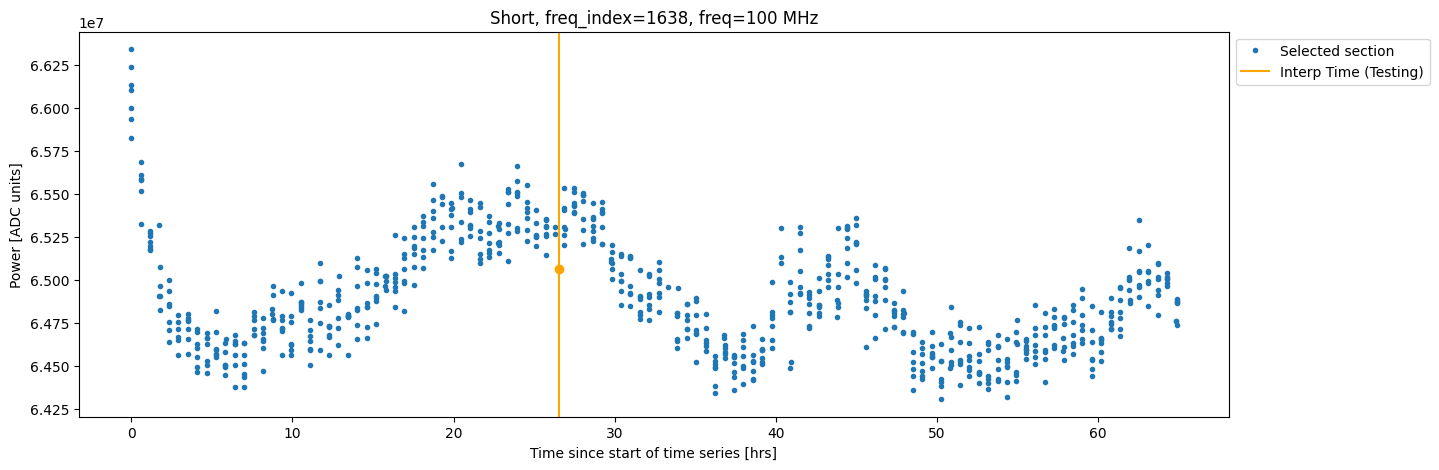

In [74]:
# Let's plot the result

plt.figure(figsize=(20,5))
plt.plot((tt-tt[0])/3600,dd[:,freq_index],'.',label='Selected section',zorder=0)
plt.axvline(x=(interp_time-tt[0])/3600,label='Interp Time (Testing)',color='orange',zorder=1) 
plt.scatter((interp_time-tt[0])/3600,dinterp,color='orange')
plt.xlabel('Time since start of time series [hrs]')
plt.ylabel('Power [ADC units]')
plt.title('Short, freq_index='+str(freq_index)+', freq='+str(freq)+' MHz')
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.subplots_adjust(right=0.7)
plt.show()

Hmmmm ok this does not look good.
Try plotting the weights to make sure it works?
Maybe the problem is with the proper inversion of the C matrix. Look into matrix decomposition tricks from phys 512.

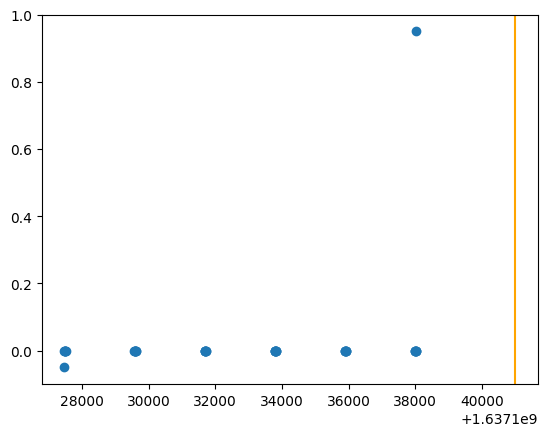

In [208]:
# plt.scatter(tt[abs(w)<100],w[abs(w)<100])
plt.scatter(t_red,w)
plt.axvline(x=interp_time,label='Interp Time (Testing)',color='orange') 
plt.show()

# why does this look like zero sometimes  and random other times????
# tt[w>200]